In [3]:
import arviz as az
import pandas as pd
import numpy as np
import sqlite3
import os
import pprint
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from helper import *
import bambi as bmb
import pymc as pm
from multiprocessing import cpu_count

pp = pprint.PrettyPrinter(indent=2)

%matplotlib inline

# Data Collection

In [4]:
current_folder = os.path.abspath('')
db_file = os.path.join(current_folder, r"data/data.db")
db = sqlite3.connect(db_file)

In [5]:
query = r""" 
    SELECT events, launch_angle, launch_speed, estimated_ba_using_speedangle, hc_x, hc_y, hit_distance_sc, stand, bb_type
    FROM statcast
    WHERE type = 'X' AND
        events NOT LIKE 'sac_%'
"""
raw_data = pd.read_sql_query(query, db)

In [6]:
data = raw_data.copy()
hit_events = {
    'single':1,
    'double':2,
    'triple':3,
    'home_run':4
}

data = data.dropna(axis='index')
data['is_hit'] = np.where(data['events'].isin(hit_events.keys()), 1, 0)
data['bases_earned'] = data.apply(get_bases_earned, axis='columns')
data['spray_angle'] = data.apply(get_spray_angle, axis='columns')

In [7]:
rng = np.random.RandomState(seed=6420)
X_train, X_test, y_train, y_test = train_test_split(data.drop("is_hit", axis="columns"), data["is_hit"], test_size = 0.3, random_state=rng)

# Standard Logisitic Regression

{ 'Accuracy': 0.6842700258397932,
  'F1 Score': 0.1747572815533981,
  'Sensitivity': 0.10157016683022571,
  'Specificity': 0.9701492537313433}


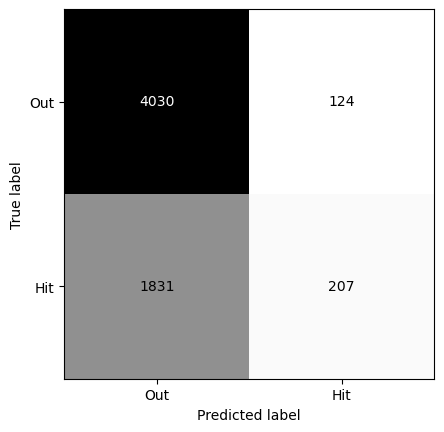

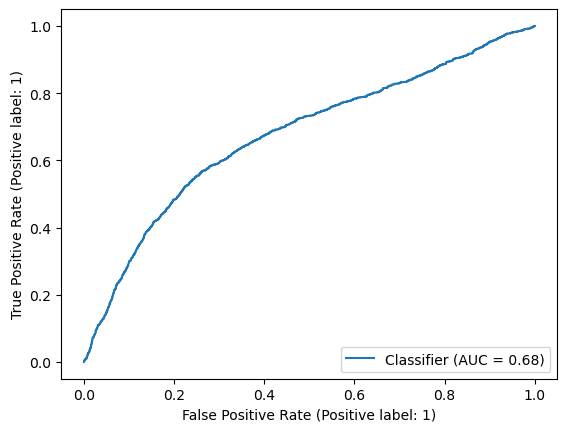

In [8]:
speed_angle_train = X_train[["launch_speed", "launch_angle"]]
# speed_angle_train["interaction"] = speed_angle_train["launch_angle"] * speed_angle_train["launch_speed"]
speed_angle_test = X_test[["launch_speed", "launch_angle"]]
# speed_angle_test["interaction"] = speed_angle_test["launch_angle"] * speed_angle_test["launch_speed"]
logit_model = LogisticRegression().fit(speed_angle_train, y_train)
logit_pred = logit_model.predict_proba(speed_angle_test)
logit_pred = [p[1] for p in logit_pred]

ConfusionMatrixDisplay.from_predictions(y_test, np.round(logit_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, logit_pred);
pp.pprint(cm_scores(y_test, np.round(logit_pred)))

# Bayesian Model

In [38]:
bayes_data = pd.concat([y_train, X_train], axis="columns")
priors = {
    "launch_speed": bmb.Prior("Normal", mu=0, sigma=10),
    "launch_angle": bmb.Prior("Normal", mu=0, sigma=10)
}
bayes_model = bmb.Model("is_hit ~ launch_angle + launch_speed", data=bayes_data, priors=priors, family="bernoulli")
model_filepath = os.path.join(current_folder, r"models/bayes_speed_angle.model")
if os.path.exists(model_filepath):
    bayes_results = az.from_netcdf(model_filepath)
else:
    bayes_results = bayes_model.fit(chains=4, cores=cpu_count(), inference_method="nuts_numpyro")
    az.to_netcdf(bayes_results, model_filepath)

In [39]:
bayes_model.predict(bayes_results, data=X_test, kind="pps")

{ 'Accuracy': 0.6844315245478036,
  'F1 Score': 0.17552742616033754,
  'Sensitivity': 0.10206084396467124,
  'Specificity': 0.9701492537313433}


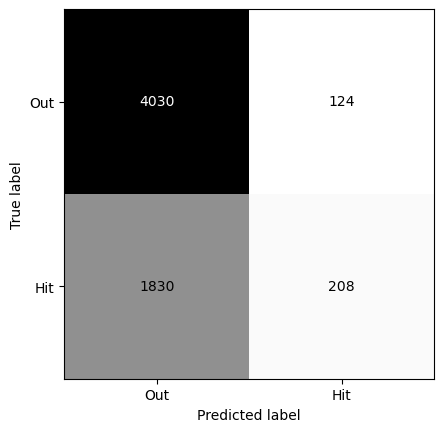

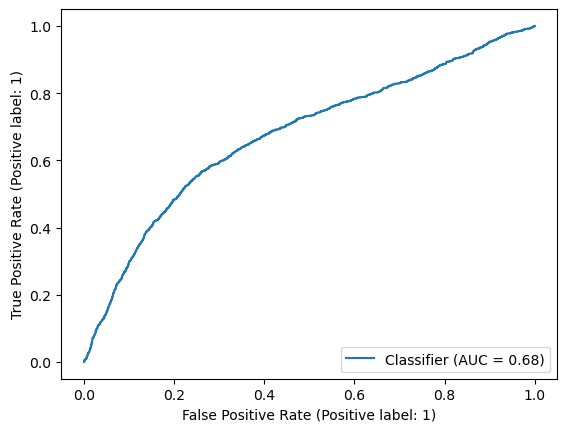

In [40]:
bayes_pred = bayes_results.posterior["is_hit_mean"].values.mean(0).mean(0)
ConfusionMatrixDisplay.from_predictions(y_test, np.round(bayes_pred), display_labels=["Out", "Hit"], colorbar=False, cmap="binary");
RocCurveDisplay.from_predictions(y_test, bayes_pred);
pp.pprint(cm_scores(y_test, np.round(bayes_pred)))


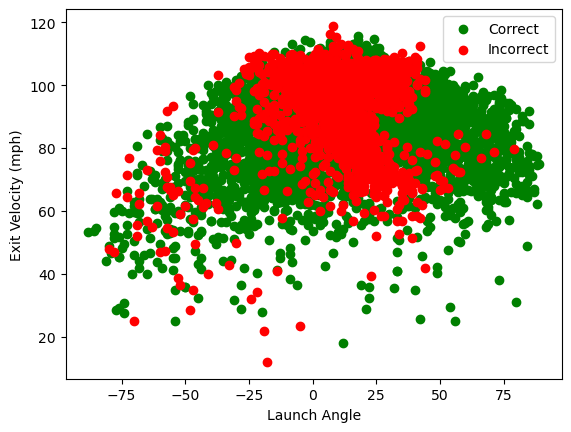

In [41]:
test_with_results = y_test == np.round(bayes_pred)
test_with_results.name="correct"
test_with_results = pd.concat([test_with_results, y_test, X_test], axis="columns")
correct_pred = test_with_results[test_with_results["correct"]]
incorrect_pred = test_with_results[~test_with_results['correct']]
plt.scatter(correct_pred['launch_angle'], correct_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_pred['launch_angle'], incorrect_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();


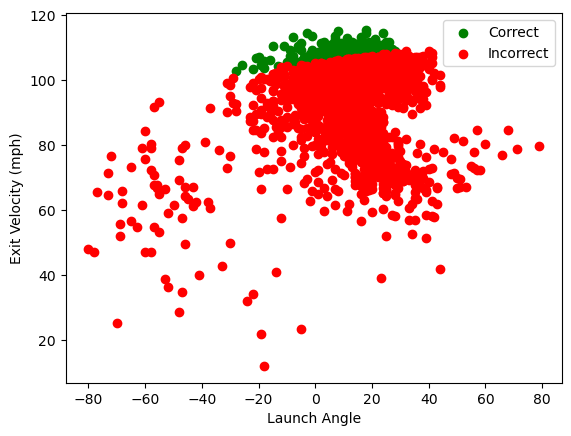

In [42]:
correct_hit_pred = test_with_results[test_with_results["correct"] & test_with_results["is_hit"]]
incorrect_hit_pred = test_with_results[~test_with_results['correct'] & test_with_results["is_hit"]]
plt.scatter(correct_hit_pred['launch_angle'], correct_hit_pred['launch_speed'], c="green",label="Correct")
plt.scatter(incorrect_hit_pred['launch_angle'], incorrect_hit_pred['launch_speed'], c="red",label="Incorrect")
plt.xlabel("Launch Angle")
plt.ylabel("Exit Velocity (mph)")
plt.legend();


## Bayes with Type Level Effects

In [43]:
priors_bbtype = {
    "(1|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    "(launch_speed|bb_type)": bmb.Prior("Normal", mu=0, sigma=10),
    "launch_angle": bmb.Prior("Normal", mu=0, sigma=10)
}
bayes_bb_type_model = bmb.Model("is_hit ~ launch_angle + (1|bb_type) + (launch_speed|bb_type)", data=bayes_data, priors=priors_bbtype, family="bernoulli")
model_filepath = os.path.join(current_folder, r"models/bayes_with_bbtype_effects.model")
if os.path.exists(model_filepath):
    bayes_bbtype_results = az.from_netcdf(model_filepath)
else:
    bayes_bbtype_results = bayes_model.fit(chains=4, cores=cpu_count(), inference_method="nuts_numpyro")
    bayes_bbtype_results = az.to_netcdf(model_filepath)

Modeling the probability that is_hit==1


Compiling...
Compilation time =  0:00:03.792976
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [35]:
bayes_results

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data